In [1]:
from strategy.financialpredict import FinancialPredict
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
import matplotlib.pyplot as plt
from statistics import mean
import numpy as np

In [2]:
start_date = datetime(2016,1,1)
end_date = datetime(2021,1,1)
fp = FinancialPredict(start_date,end_date)

In [3]:
fp.subscribe()

In [4]:
market = fp.subscriptions["market"]["db"]
product_db = fp.subscriptions["stock_category"]["db"]
categories_nums = 2
market.connect()
product_db.connect()
financials = market.retrieve("unified_financials")
sp5 = market.retrieve("sp500")
categories = product_db.retrieve("sim")
product_db.disconnect()
for i in range(40):
    financials.drop(str(i),inplace=True,axis=1,errors="ignore")
financials["year"] = [row[1]["year"] + 1 if row[1]["quarter"] == 4 else row[1]["year"] for row in financials.iterrows()]
financials["quarter"] = [1 if row[1]["quarter"] == 4 else row[1]["quarter"] + 1 for row in financials.iterrows()]
financials = financials.groupby(["year","quarter","ticker"]).mean().reset_index()
financials["date"] = [datetime(row[1]["year"], row[1]["quarter"] * 3 -  2, 1) for row in financials.iterrows()]
start = fp.start_date.year
end = fp.end_date.year
financial_factors = [x for x in financials.columns if x not in ["year","quarter","ticker","date"]]
yearly_gap = 1
fp.db.connect()
initial_data = fp.db.retrieve("transformed")
labels = initial_data.merge(categories,on=["year","quarter","ticker"],how="left")
factors = financials.merge(categories,on=["year","quarter","ticker"],how="left")
factors["date"] = [datetime(row[1]["year"], row[1]["quarter"] * 3 -  2, 1) for row in factors.iterrows()]
model_training_year = fp.modeling_params["model_training_year"]
start_year = fp.start_date.year
end_year = fp.end_date.year
sims = []
market.disconnect()

In [5]:
market.connect()
for year in tqdm(range(start_year,start_year+1),desc="financial_predict_sim_year"):
    for quarter in range(1,2):
        quarterly_categories = labels[(labels["year"]==year) & (labels["quarter"]==quarter)]
        for category in list(labels[f"{categories_nums}_classification"].unique()[2:3]):
            try:
                category_tickers = labels[labels[f"{categories_nums}_classification"]==category]["ticker"].unique()
                training_factors = factors[factors["ticker"].isin(list(category_tickers))]
                training_factors.sort_values("date",inplace=True)
                if quarter == 1:
                    new_quarter = 4
                    new_year = year - 1
                else:
                    new_quarter = quarter - 1
                    new_year = year
                last_index = training_factors[(training_factors["year"] == new_year) & (training_factors["quarter"]==new_quarter)].index.values.tolist()[0]
                spliced_training = training_factors.iloc[:last_index]
                relevant_factors = spliced_training[(spliced_training["year"] < year) & (spliced_training["year"]>=year-model_training_year)]
                training_labels = labels[labels["ticker"].isin(list(category_tickers))]
                training_labels.sort_values("date",inplace=True)
                last_index = training_labels[(training_labels["year"] == new_year) & (training_labels["quarter"]==new_quarter)].index.values.tolist()[0]
                training_labels = training_labels.iloc[:last_index]
                relevant_labels = training_labels[(training_labels["year"] < year) & (training_labels["year"]>=year-model_training_year)]
                prediction_data = training_factors[(training_factors["year"]==year) & (training_factors["quarter"]==quarter)]
                relevant = relevant_factors.merge(relevant_labels,on=["year","quarter","ticker"],how="left").dropna()
                relevant.reset_index(inplace=True)
                print(year,quarter,category,len(category_tickers),relevant.index.size,prediction_data.index.size)
                X = relevant[financial_factors]
                y = relevant["adjclose"]
                models = m.regression({"X":X,"y":y})
                models["year"] = year
                models["quarter"] = quarter
                models["category"] = category
                sim = prediction_data
                sim = sim.groupby(["year","quarter","ticker"]).mean().reset_index()
                for i in range(models.index.size):
                    model = models.iloc[i]
                    api = model["api"]
                    score = model["score"]
                    if score >= fp.modeling_params["score_requirement"]/100:
                        sim[f"{api}_prediction"] = model["model"].predict(sim[financial_factors])
                        sim[f"{api}_score"] = model["score"].item()
#                 stuff = []
#                 for ticker in category_tickers:
#                     ticker_data = market.retrieve_ticker_prices("prices",ticker)
#                     stuff.append(ticker_data)
#                 prices = p.column_date_processing(pd.concat(stuff))
#                 prices["year"] = [x.year for x in prices["date"]]
#                 prices["quarter"] = [x.quarter for x in prices["date"]]
#                 sim = prices.merge(sim,on=["year","quarter","ticker"],how="left").dropna()
#                 sim["categories"] = categories_nums
#                 final_cols = ["date","ticker","adjclose","categories"]
#                 final_cols.extend([x for x in list(sim.columns) if "prediction" in x or "score" in x])
#                 sim = sim[final_cols]
#                 sim.fillna(0,inplace=True)
#                 sim["prediction"] = [np.nanmean([row[1][x] for x in sim.columns if "prediction" in x and row[1][x] != 0]) for row in sim.iterrows()]
#                 sim["score"] = [np.nanmean([row[1][x] for x in sim.columns if "score" in x and row[1][x] != 0]) for row in sim.iterrows()]
#                 sims.append(sim)
            except Exception as e:
                print(year,quarter,category,str(e)) 
                continue
# fp.simmed = True
fp.db.disconnect()
market.disconnect()

financial_predict_sim_year:   0%|                                                                                                         | 0/1 [00:00<?, ?it/s]

2016 1 Information Technology 73 1008 69


financial_predict_sim_year: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


In [10]:
analysis = pd.concat(sims)
analysis["ticker"].unique()

array(['ACN', 'AMD', 'AKAM', 'APH', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ANET',
       'ADSK', 'ADP', 'BR', 'CDNS', 'CDW', 'CSCO', 'CTXS', 'CTSH', 'GLW',
       'ENPH', 'FFIV', 'FIS', 'FISV', 'FLT', 'FTNT', 'IT', 'GPN', 'HPE',
       'HPQ', 'INTC', 'IBM', 'INTU', 'IPGP', 'JKHY', 'JNPR', 'KEYS',
       'KLAC', 'LRCX', 'MA', 'MXIM', 'MCHP', 'MU', 'MSFT', 'MPWR', 'MSI',
       'NTAP', 'NLOK', 'NVDA', 'ORCL', 'PAYX', 'PAYC', 'PYPL', 'PTC',
       'QRVO', 'QCOM', 'CRM', 'STX', 'NOW', 'SWKS', 'SNPS', 'TEL', 'TER',
       'TXN', 'TRMB', 'TYL', 'VRSN', 'V', 'WDC', 'WU', 'XLNX'],
      dtype=object)

In [11]:
sim

,date,ticker,adjclose,categories,xgb_prediction,xgb_score,cat_prediction,cat_score,prediction,score
3636,2016-01-04,ACN,92.533905,2,73.483109,0.937193,74.903633,0.928193,74.193371,0.932693
3637,2016-01-05,ACN,93.015521,2,73.483109,0.937193,74.903633,0.928193,74.193371,0.932693
3638,2016-01-06,ACN,92.833780,2,73.483109,0.937193,74.903633,0.928193,74.193371,0.932693
3639,2016-01-07,ACN,90.107651,2,73.483109,0.937193,74.903633,0.928193,74.193371,0.932693
3640,2016-01-08,ACN,89.235289,2,73.483109,0.937193,74.903633,0.928193,74.193371,0.932693
...,...,...,...,...,...,...,...,...,...,...
402214,2016-03-24,XLNX,42.963967,2,36.738091,0.937193,36.109002,0.928193,36.423546,0.932693
402215,2016-03-28,XLNX,42.982242,2,36.738091,0.937193,36.109002,0.928193,36.423546,0.932693
402216,2016-03-29,XLNX,43.174127,2,36.738091,0.937193,36.109002,0.928193,36.423546,0.932693
402217,2016-03-30,XLNX,43.740645,2,36.738091,0.937193,36.109002,0.928193,36.423546,0.932693


In [12]:
light = models["model"].iloc[2]

In [13]:
light

'For early stopping, at least one dataset and eval metric is required for evaluation'

In [53]:
analysis["year"] = [x.year for x in analysis["date"]]
analysis["quarter"] = [x.quarter for x in analysis["date"]]
analysis = analysis.groupby(["year","quarter","ticker"]).mean().reset_index()
analysis["date"] = [datetime(row[1]["year"], row[1]["quarter"] * 3 -  2, 1) for row in analysis.iterrows()]

In [57]:
analysis.dropna()

,year,quarter,ticker,adjclose,categories,prediction,score,xgb_prediction,xgb_score,cat_prediction,cat_score,date
466,2016,2,A,41.218281,1.0,40.144404,0.874613,41.404575,0.859713,38.884232,0.889514,2016-04-01
467,2016,2,AAL,32.444042,1.0,90.179373,0.874613,101.698723,0.859713,78.660023,0.889514,2016-04-01
468,2016,2,AAP,150.441181,1.0,140.465315,0.874613,147.814087,0.859713,133.116542,0.889514,2016-04-01
469,2016,2,AAPL,23.120755,1.0,45.515128,0.874613,49.369972,0.859713,41.660284,0.889514,2016-04-01
470,2016,2,ABBV,48.102242,1.0,48.665135,0.874613,48.364246,0.859713,48.966023,0.889514,2016-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...
9955,2021,1,XEL,62.014017,1.0,54.901227,0.907777,50.734703,0.894165,59.067751,0.921389,2021-01-01
9956,2021,1,XLNX,133.310656,1.0,59.247069,0.907777,61.311623,0.894165,57.182516,0.921389,2021-01-01
9957,2021,1,XOM,50.592233,1.0,75.931951,0.907777,76.512955,0.894165,75.350948,0.921389,2021-01-01
9958,2021,1,XRAY,57.708835,1.0,70.457032,0.907777,66.254669,0.894165,74.659394,0.921389,2021-01-01


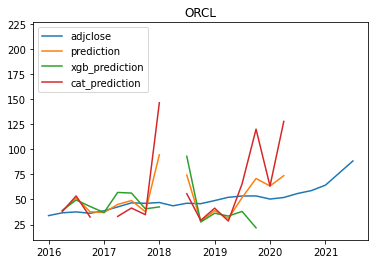

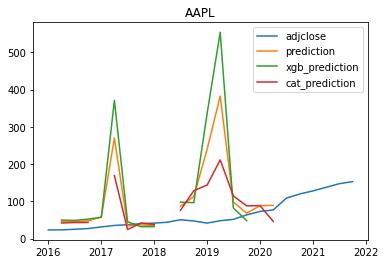

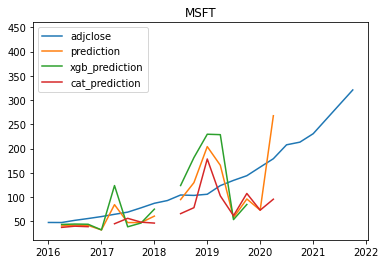

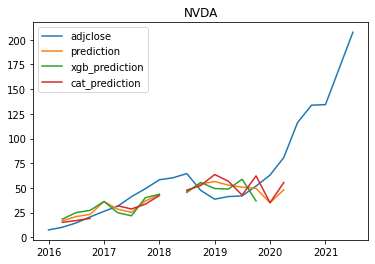

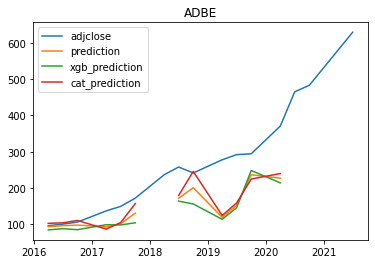

In [55]:
for ticker in ["ORCL","AAPL","MSFT","NVDA","ADBE"]:
    ticker_example = analysis[analysis["ticker"]==ticker].sort_values("date")
    plt.plot(ticker_example["date"],ticker_example["adjclose"])
    for col in [x for x in analysis.columns if "prediction" in x]:
        plt.plot(ticker_example["date"],ticker_example[col])
    legend = ["adjclose"]
    legend.extend([x for x in analysis.columns if "prediction" in x])
    plt.legend(legend)
    plt.title(ticker)
    plt.show()

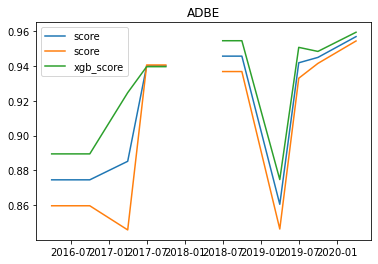

In [56]:
for col in [x for x in analysis.columns if "score" in x]:
    plt.plot(analysis["date"],analysis[col])
legend = ["score"]
legend.extend([x for x in analysis.columns if "score" in x])
plt.legend(legend)
plt.title(ticker)
plt.show()